# Evolutionary Algorithm Visualization

This notebook visualizes the progress and results of the Evolutionary Algorithm for ODE discovery.
We will run the EA for a few generations and plot:
1. Fitness evolution (MSE trend) for each island.
2. Trajectories of the best discovered model vs. the ground truth.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure code is in path
sys.path.append(os.getcwd())

from data.generate_data import WarfarinTMDDDataset
from evolution.llm_interface import LLMClient
from evolution.models import Island, Individual
from evolution.algorithm import EvolutionEngine
from evolution.models import integrate_euler

# Setup plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
print("--- Setting up Data ---")

# 1. Setup Data (Same as previous experiments)
true_params = {
    'CL': 0.1, 'V1': 1.0, 'Q': 0.5, 'V2': 2.0,
    'kon': 0.01, 'koff': 0.005, 'kdeg': 0.001, 'ksyn': 0.002, 
    'initial_state': [10.0, 0.0, 0.0, 5.0],
    't_start': 0, 't_end': 50, 'num_points': 50
}
generator = WarfarinTMDDDataset(generation_parameters=true_params)
gt_data = generator.generate()
time_points = generator.get_time_points()
obs_indices = [0, 2] # x1, x3

observed_data = gt_data[:, obs_indices]

--- Setting up Data ---


In [ ]:
print("--- Setting up EA ---")

# 2. Setup Islands
# We will run small populations for visualization speed

n_init_pop = 20

islands = [
    Island(num_vars=2),
    Island(num_vars=2),
    Island(num_vars=3),
    Island(num_vars=3),
    Island(num_vars=4),
    Island(num_vars=4)
]

# 3. Initialize Population
llm = LLMClient()
problem_desc = generator.description + "\n\n" + "The variables descriptions are: \n"
for idx in obs_indices:
    problem_desc += f"{idx}: {generator.variables_description[idx]}\n"
llm.set_problem_description(problem_desc)
print("Initializing Populations (This may take a minute)... ")
for island in islands:
    print(f"  Initializing Island (Dim {island.num_vars})...")
    while len(island.population) < n_init_pop:
        code = llm.generate_initial_model(island.num_vars)
        if code:
            ind = Individual(code)
            if ind.compile():
                ind.evaluate(observed_data, obs_indices, time_points)
                island.add_individual(ind)
                print(".", end="", flush=True)
        else:
            print("x", end="", flush=True)
    print()

--- Setting up EA ---
Problem description added to System Prompt.
Initializing Populations (This may take a minute)... 
  Initializing Island (Dim 2)...
.....
  Initializing Island (Dim 3)...
.....
  Initializing Island (Dim 4)...
.....


In [4]:
for island in islands:
    for pop in island.population:
        print(pop.fitness)

0.0001194648357341066
0.000124171725474298
0.00010915166058111936
0.00013173074694350362
0.0798867717385292
0.21358686685562134
0.03671804815530777
0.13999220728874207
0.13545797765254974
0.13828298449516296
0.08629591763019562
0.15246650576591492
0.000772473867982626
0.008282769471406937
0.15539968013763428


In [5]:
# 4. Run Evolution Loop
data_pkg = {'observed_data': observed_data}
engine = EvolutionEngine(islands, llm, data_pkg, obs_indices, time_points, n_iterations=20)

num_generations = 50 # Run for 20 generations
history = []

print("Starting Evolution...")
for g in range(num_generations):
    gen_stats = engine.run_generation()
    history.extend(gen_stats)
    if engine.stop_flag:
        print("Stagnation detected. Stopping evolution.")
        break
# Save logs for analysis
engine.save_logs("evolution_history.json")

EvolutionEngine loaded evolution/config.json
Starting Evolution...
Logging initial population...
--- Generation 0 (Stagnation: 0/20) ---
Evolving Island 2 (Vars: 4)...
--- Generation 1 (Stagnation: 1/20) ---
Evolving Island 1 (Vars: 3)...
--- Generation 2 (Stagnation: 2/20) ---
Evolving Island 1 (Vars: 3)...
--- Generation 3 (Stagnation: 3/20) ---
Evolving Island 2 (Vars: 4)...
--- Generation 4 (Stagnation: 4/20) ---
Evolving Island 2 (Vars: 4)...
--- Generation 5 (Stagnation: 5/20) ---
Evolving Island 0 (Vars: 2)...
--- Generation 6 (Stagnation: 6/20) ---
Evolving Island 0 (Vars: 2)...
    Improvement found! New Best: 0.0001
--- Generation 7 (Stagnation: 0/20) ---
Evolving Island 0 (Vars: 2)...
--- Generation 8 (Stagnation: 1/20) ---
Evolving Island 0 (Vars: 2)...
--- Generation 9 (Stagnation: 2/20) ---
Evolving Island 2 (Vars: 4)...
--- Generation 10 (Stagnation: 3/20) ---
Evolving Island 1 (Vars: 3)...
--- Generation 11 (Stagnation: 4/20) ---
Evolving Island 1 (Vars: 3)...
--- Gener

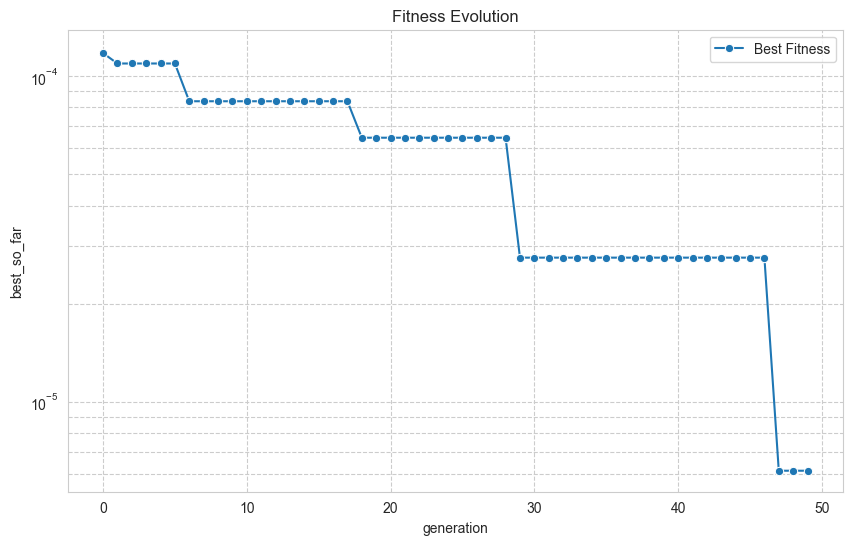

Tracing Best Individual found: 07c2a6cb (Fitness: 0.0000)

=== Evolution Trace for 07c2a6cb... ===
History Length: 4 recorded generations

[Gen 0] Step 1: INIT -> Child 2cfd3f08
Fitness: 0.000109
------------------------------
  [Child 2cfd3f08] Resulting Code Summary:
--- Parameters ---
  k_el: 0.1 # Elimination rate of free Warfarin
  k_bind: 0.01 # Binding rate to the target
  k_unbind: 0.005 # Unbinding rate from the target

--- ODE System ---
  dx1_dt = -k_el * x1 - k_bind * x1 + k_unbind * x2
  dx2_dt = k_bind * x1 - k_unbind * x2

[Gen 7] Step 2: MUTATION -> Child ed079e66
Fitness: 0.000131
Instruction: Perform a mutation operation on these dynamics, ie Change its dynamics to propose a new ODE system

  --- Parent(s) used: ['2cfd3f08'] ---
  [Parent 2cfd3f08] Summary:
    --- Parameters ---
      k_el: 0.1 # Elimination rate of free Warfarin
      k_bind: 0.01 # Binding rate to the target
      k_unbind: 0.005 # Unbinding rate from the target
    
    --- ODE System ---
      dx

In [6]:
# 5. Analyze Results
import evolution.analysis as analysis

# Reload logs explicitly to handle any format quirks
log_data = analysis.load_history("evolution_history.json")

# 1. Plot Fitness Trajectories
analysis.plot_fitness_trajectories(log_data)

# 2. Trace Best Individual
analysis.print_evolution_trace(log_data)

In [7]:
# 2. Trace Best Individual
analysis.print_evolution_trace(log_data)

Tracing Best Individual found: 07c2a6cb (Fitness: 0.0000)

=== Evolution Trace for 07c2a6cb... ===
History Length: 4 recorded generations

[Gen 0] Step 1: INIT -> Child 2cfd3f08
Fitness: 0.000109
------------------------------
  [Child 2cfd3f08] Resulting Code Summary:
--- Parameters ---
  k_el: 0.1 # Elimination rate of free Warfarin
  k_bind: 0.01 # Binding rate to the target
  k_unbind: 0.005 # Unbinding rate from the target

--- ODE System ---
  dx1_dt = -k_el * x1 - k_bind * x1 + k_unbind * x2
  dx2_dt = k_bind * x1 - k_unbind * x2

[Gen 7] Step 2: MUTATION -> Child ed079e66
Fitness: 0.000131
Instruction: Perform a mutation operation on these dynamics, ie Change its dynamics to propose a new ODE system

  --- Parent(s) used: ['2cfd3f08'] ---
  [Parent 2cfd3f08] Summary:
    --- Parameters ---
      k_el: 0.1 # Elimination rate of free Warfarin
      k_bind: 0.01 # Binding rate to the target
      k_unbind: 0.005 # Unbinding rate from the target
    
    --- ODE System ---
      dx

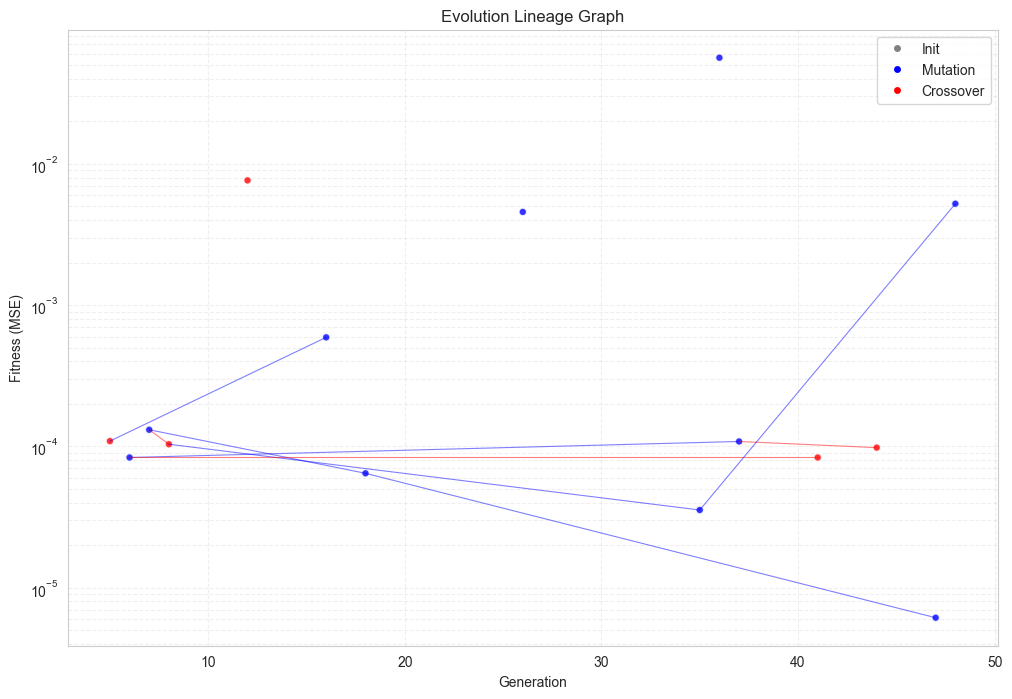

In [25]:
# 3. Plot Lineage Graph
analysis.plot_lineage_graph(log_data = log_data, island_id=islands[0].id)
# analysis.plot_lineage_graph(log_data = log_data)

In [23]:
print(islands[2].get_best().code)

import torch
import torch.nn as nn

class ProposedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_vars = 4
        
        # Define learnable parameters here
        self.params = nn.ParameterDict({
            'k1': nn.Parameter(torch.tensor(0.15)),  # Rate constant for x1 dynamics (from Model 1)
            'k2': nn.Parameter(torch.tensor(0.05)),  # Rate constant for x2 dynamics (from Model 1)
            'k3': nn.Parameter(torch.tensor(0.2)),   # Rate constant for x3 dynamics (from Model 1)
            'k4': nn.Parameter(torch.tensor(0.07)),  # Rate constant for x4 dynamics (from Model 1)
            'k_abs': nn.Parameter(torch.tensor(0.1)),  # Warfarin absorption rate constant (from Model 2)
            'k_trans': nn.Parameter(torch.tensor(0.03)),  # Transfer rate constant between compartments (from Model 2)
            'kon': nn.Parameter(torch.tensor(0.02)), # Binding rate constant (from Model 1)
            'koff': nn.Parameter(torch.tensor

In [17]:
analysis.print_evolution_trace(log_data, individual_id = islands[0].population[2].id)


=== Evolution Trace for 2cfd3f08... ===
History Length: 1 recorded generations

[Gen 0] Step 1: INIT -> Child 2cfd3f08
Fitness: 0.000109
------------------------------
  [Child 2cfd3f08] Resulting Code Summary:
--- Parameters ---
  k_el: 0.1 # Elimination rate of free Warfarin
  k_bind: 0.01 # Binding rate to the target
  k_unbind: 0.005 # Unbinding rate from the target

--- ODE System ---
  dx1_dt = -k_el * x1 - k_bind * x1 + k_unbind * x2
  dx2_dt = k_bind * x1 - k_unbind * x2


In [18]:
print(islands[0].population[2].code)

import torch
import torch.nn as nn

class ProposedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_vars = 2
        
        # Define learnable parameters here
        self.params = nn.ParameterDict({
            'k_el': nn.Parameter(torch.tensor(0.1)),  # Elimination rate of free Warfarin
            'k_bind': nn.Parameter(torch.tensor(0.01)),  # Binding rate to the target
            'k_unbind': nn.Parameter(torch.tensor(0.005)),  # Unbinding rate from the target
        })
        
    def forward(self, state):
        # state is a tensor of size (..., 2)
        # Unpack state variables using slicing:
        x1 = state[..., 0]  # Free Warfarin concentration
        x2 = state[..., 1]  # Target-bound Warfarin concentration
        
        # access params via self.params
        k_el = self.params['k_el']
        k_bind = self.params['k_bind']
        k_unbind = self.params['k_unbind']
        
        # Compute derivatives dx/dt
        dx1_dt 

Best Overall Fitness: 0.0000
Best Model Dimension: 2


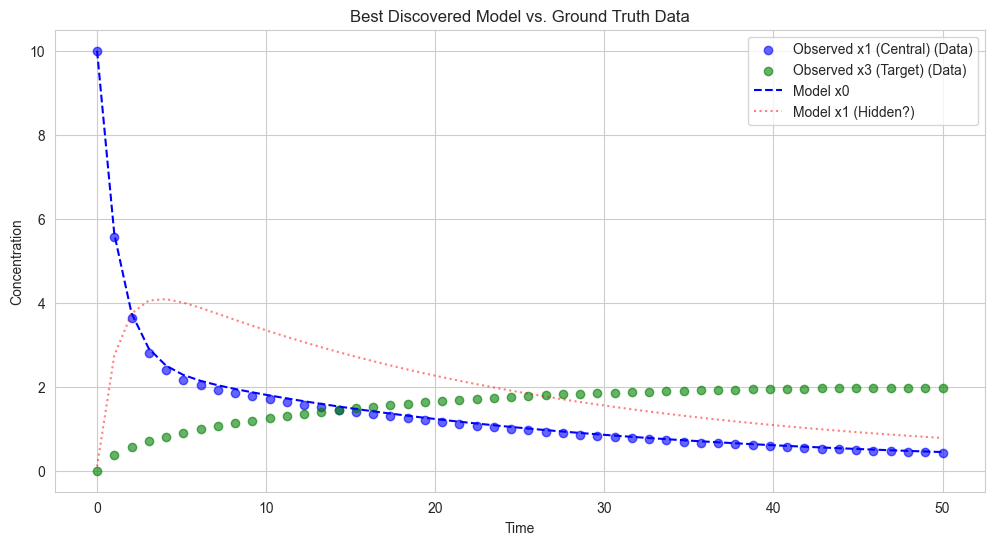

In [19]:
# 6. Visualize Best Model Trajectory
best_overall = None
for island in islands:
    b = island.get_best()
    if b:
        if best_overall is None or b.fitness < best_overall.fitness:
            best_overall = b

print(f"Best Overall Fitness: {best_overall.fitness:.4f}")
print(f"Best Model Dimension: {best_overall.model.num_vars}")

# Simulate Best Model
# Re-integrate to get full trajectory
# Note: reconstruction of x0 logic must be identical to 'evaluate'
x0 = torch.zeros(best_overall.model.num_vars)
for i, obs_idx in enumerate(obs_indices):
    if obs_idx < best_overall.model.num_vars:
        x0[obs_idx] = observed_data[0, i]
x0[x0 == 0] = 0.1

with torch.no_grad():
    pred_traj = integrate_euler(best_overall.model, x0, time_points).numpy()

# Plotting
plt.figure(figsize=(12, 6))

# Plot Ground Truth Observations
colors = ['blue', 'green']
labels = ['Observed x1 (Central)', 'Observed x3 (Target)']

for i, obs_idx in enumerate(obs_indices):
    plt.scatter(time_points, observed_data[:, i], color=colors[i], label=f'{labels[i]} (Data)', alpha=0.6)

# Plot Model Predictions
# We plot the indices that theoretically match.
# Assumption: Model indices 0 and 1 match obs indices 0 and 2 if dim=2? 
# Or we assume naive mapping: index 0 -> obs 0, index 2 -> obs 1 if available?
# In the 'evaluate' method, we matched by explicit index.
# for i, obs_idx in enumerate(obs_indices):
#    if obs_idx in valid_indices...

for i, obs_idx in enumerate(obs_indices):
    if obs_idx < pred_traj.shape[1]:
        plt.plot(time_points, pred_traj[:, obs_idx], color=colors[i], linestyle='--', label=f'Model x{obs_idx}')

# Plot Hidden if available (e.g. x2)
if pred_traj.shape[1] > 1 and 1 not in obs_indices:
    plt.plot(time_points, pred_traj[:, 1], color='red', linestyle=':', label='Model x1 (Hidden?)', alpha=0.5)

plt.title('Best Discovered Model vs. Ground Truth Data')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [8]:
print("Best Discovered Code:")
print(best_overall.code)

Best Discovered Code:
import torch
import torch.nn as nn

class ProposedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_vars = 3
        
        # Define learnable parameters here
        self.params = nn.ParameterDict({
            'k_clearance': nn.Parameter(torch.tensor(0.1)),  # Clearance rate from central compartment
            'k_transfer': nn.Parameter(torch.tensor(0.05)),  # Transfer rate between central and peripheral compartments
            'k_reverse_transfer': nn.Parameter(torch.tensor(0.15)), # Peripheral-to-Central transfer rate
            'k_bind': nn.Parameter(torch.tensor(0.02)),      # Binding rate to target
            'k_unbind': nn.Parameter(torch.tensor(0.01)),    # Unbinding rate from target
            'k_elim': nn.Parameter(torch.tensor(0.04)),      # Elimination rate constant
            'k_degrade': nn.Parameter(torch.tensor(0.03))    # Degradation rate constant in peripheral compartment
        })
        
    def fo